In [1]:
# Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Определяем параметры модели
VALIDATION_SPLIT = 0.2
SEED = 42
IMAGE_SIZE = (28, 28)
EPOCHS = 10
BATCH_SIZE = 32

In [3]:
# Считываем тренировочные данные
train_df = pd.read_csv('fmnist_train.csv', sep=',')
train_df.dropna(inplace=True)
class_num = train_df['label'].nunique()

print(train_df.shape)
print(class_num)

(17039, 786)
10


In [4]:
# Считываем тестовые данные
test_df = pd.read_csv('fmnist_test.csv', sep=',')
test_df.dropna(inplace=True)

print(test_df.shape)

(10000, 785)


In [5]:
# Выделяем признаки (пиксели) и метки
X = train_df.drop(columns=['label', 'Id']).values # Все столбцы между "label" и "Id"
y = train_df['label'].values # Метки классов

# Преобразовываем данные в формат (28, 28, 1)
X = X.reshape(-1, 28, 28, 1) # Добавляем канал (1 для черно-белого изображения)

# Разделяем данные на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VALIDATION_SPLIT, random_state=SEED)

In [6]:
# Преобразовываем тестовые данные
X_test = test_df.drop(columns=['Id']).values

X_test = X_test.reshape(-1, 28, 28, 1) # Добавляем канал (1 для черно-белого изображения)

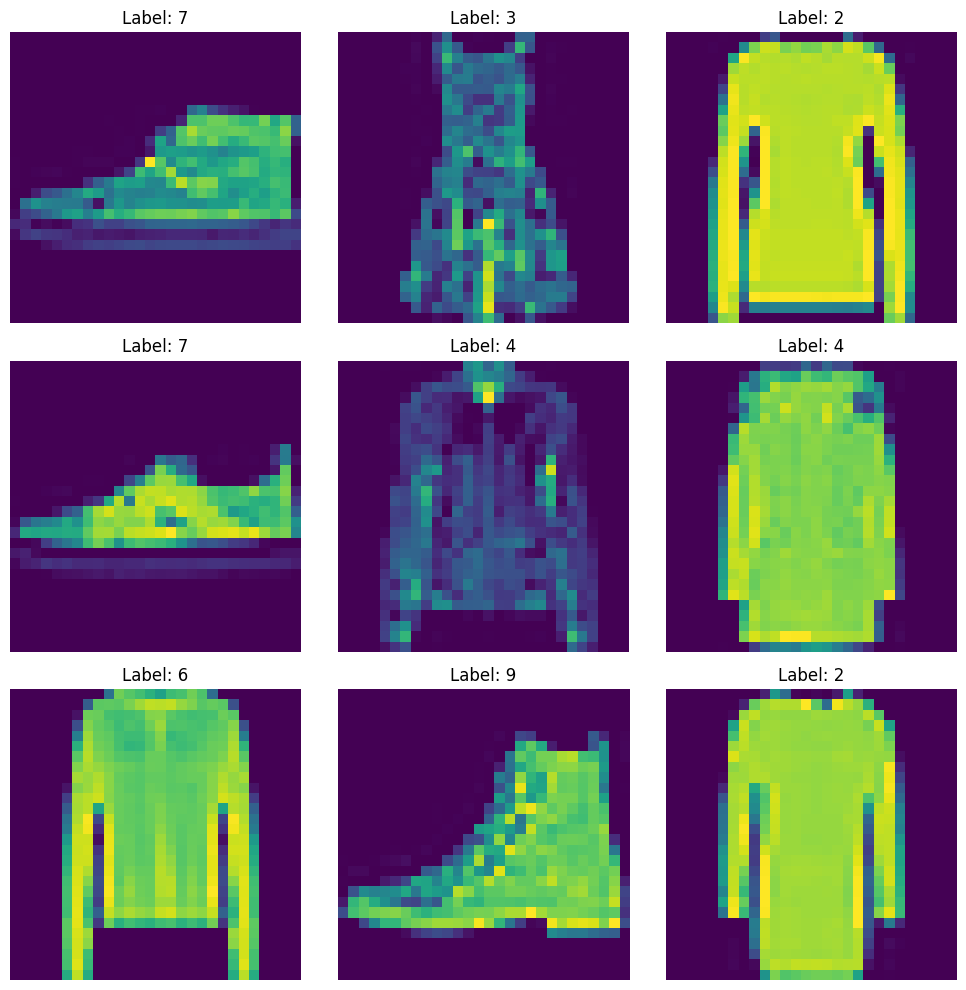

In [7]:
# Выводим на экран изображения
num_images = 9  # Количество изображений в сетке
plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i].reshape(28, 28))
    plt.title(f'Label: {y_train[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
# Делаем вспомогательную структуру для наращивания обучающей выборки
augmentation_network = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.1),
    ]
)

In [9]:
# Метод для создания модели Xception network. Ниже визуализируем структуру модели.
"""""
Модель состоит из:
- Начальных сверточных слоев для извлечения базовых признаков;
- Глубинно-разделимых сверточных блоков с остаточными связями для эффективного обучения;
- Финального глобального усреднения и полносвязного слоя для классификации.

Модель нормализует значения пикселей от 0 до 1, нормализует батчи, уменьшает пространственный размер и выполняет регуляризацию
для предотвращения переобучения.
"""""
def build_xception_network(input_shape, num_classes):
    inputs = tf.keras.Input(shape = input_shape)

    x = augmentation_network(inputs)

    x = tf.keras.layers.Rescaling(1.0 / 255)(inputs)
    x = tf.keras.layers.Conv2D(32, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    previous_block_activation = x

    for size in [128, 256, 512, 728]:
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.SeparableConv2D(size, 3, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.SeparableConv2D(size, 3, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(3, strides=2, padding='same')(x)

        residual = tf.keras.layers.Conv2D(size, 1, strides=2, padding='same')(
            previous_block_activation
        )
        x = tf.keras.layers.add([x, residual])
        previous_block_activation = x

    x = tf.keras.layers.SeparableConv2D(1024, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes

    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(units, activation=activation)(x)
    return tf.keras.Model(inputs, outputs)

In [10]:
# Создаем модель
fmnist = build_xception_network(input_shape = IMAGE_SIZE + (1,), num_classes = class_num)

In [11]:
# Отображаем структуру модели
fmnist.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 28, 28, 1)            0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['rescaling[0][0]']           
                                                                                                  
 batch_normalization (Batch  (None, 14, 14, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                               

In [12]:
# Сохраняем результаты обучения в формате Keras после каждой эпохи обучения
callbacks = [tf.keras.callbacks.ModelCheckpoint('Checkpoints/epoch_{epoch}.keras')]

# Определяем функцию потерь и метрики
fmnist.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

# Обучаем модель
model_history = fmnist.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    validation_data=(X_val, y_val)  # Передача валидационных данных
)

Epoch 1/10
426/426 [==============================] - 95s 210ms/step - loss: 0.6523 - accuracy: 0.7716 - val_loss: 2.9660 - val_accuracy: 0.1065
Epoch 2/10
426/426 [==============================] - 90s 212ms/step - loss: 0.4401 - accuracy: 0.8423 - val_loss: 0.4486 - val_accuracy: 0.8424
Epoch 3/10
426/426 [==============================] - 90s 210ms/step - loss: 0.3641 - accuracy: 0.8707 - val_loss: 0.6122 - val_accuracy: 0.8281
Epoch 4/10
426/426 [==============================] - 91s 215ms/step - loss: 0.3126 - accuracy: 0.8863 - val_loss: 0.4327 - val_accuracy: 0.8633
Epoch 5/10
426/426 [==============================] - 89s 210ms/step - loss: 0.2785 - accuracy: 0.8972 - val_loss: 0.7674 - val_accuracy: 0.7949
Epoch 6/10
426/426 [==============================] - 99s 233ms/step - loss: 0.2509 - accuracy: 0.9117 - val_loss: 0.3815 - val_accuracy: 0.8633
Epoch 7/10
426/426 [==============================] - 90s 211ms/step - loss: 0.2224 - accuracy: 0.9220 - val_loss: 0.3912 - val_ac

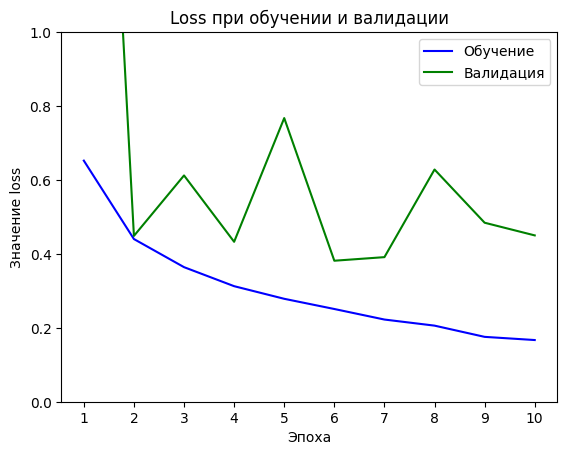

In [13]:
# Определяем характеристики процесса обучения
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = list(map(lambda epoch: epoch + 1, model_history.epoch))  # Преобразуем нумерацию эпох (с 0 -> с 1)

# Отрисовываем график обучения и валидации
plt.figure()
plt.plot(epochs, loss, 'b', label='Обучение')
plt.plot(epochs, val_loss, 'g', label='Валидация')
plt.title('Loss при обучении и валидации')
plt.xlabel('Эпоха')
plt.xticks(range(1, EPOCHS + 1))  # Используем + 1, чтобы отобразилась подпись и у последней
plt.ylabel('Значение loss')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [14]:
# Определяем эпоху с минимальным значением функции потерь на валидационном сете и вызываем веса из сохраненного чекпойнта
best_epoch = np.argmin(val_loss)
print(f'Best validation epoch: {best_epoch + 1}')

best_model = keras.saving.load_model(f'Checkpoints/epoch_{best_epoch}.keras')

Best validation epoch: 6


In [15]:
# Определяем классы на тестовой выборке
predictions = best_model.predict(X_test)

predicted_classes = np.argmax(predictions, axis=1)

# Смотрим на количество предсказанных классов
unique, counts = np.unique(predicted_classes, return_counts=True)

313/313 [==============================] - 11s 35ms/step


In [16]:
# Создаем массив идентификаторов (Id)
ids = list(range(len(predicted_classes)))  # [0, 1, 2, ..., n-1]

# Создаем DataFrame с колонками "Id" и "label"
submission_df = pd.DataFrame({
    "Id": ids,
    "label": predicted_classes
})

# Сохраняем DataFrame в CSV-файл
output_file = 'sample_submission.csv'
submission_df.to_csv(output_file, sep=',', index=False)

print(f'Предсказания успешно сохранены в файл: {output_file}')

Предсказания успешно сохранены в файл: sample_submission.csv
